In [1]:
from eoxhub import check_compatibility
check_compatibility("user-2023.03-02", dependencies=[])

# Lockdown in Venice
## Mapping the effects of mobility restriction in Venice on nightlight intensity using the NASA API

In this notebook: 
- We use the NASA STAC API to discover available data for the Nightlights data set and plot mean nightlight intensity before and after covid lockdowns
- We use the STAC items to access raster tiles for the Nightlights dataset, mosaic them together to create a single raster at a higher zoom level and then calculate pixel-by-pixel variance across the the timesteps to visualize which areas of Venice had the largest change in nightlight intensity throughout the lockdown period

In [2]:
# endpoints for nasa api
STAC_ENDPOINT_URL = "https://staging-stac.delta-backend.com"
RASTER_ENDPOINT_URL = "https://staging-raster.delta-backend.com"

In [3]:
import requests as re

# Summary of the metadata for the nightlights intensity indicator
nightlights_collection_summary = re.get(f"{STAC_ENDPOINT_URL}/collections/nightlights-hd-monthly").json()
nightlights_collection_summary

{'id': 'nightlights-hd-monthly',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.com/collections/nightlights-hd-monthly/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/nightlights-hd-monthly'}],
 'title': 'Black Marble High Definition Nightlights Monthly Dataset',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2017-07-21T00:00:00Z',
     '2021-09-30T23:59:59Z']]}},
 'license': 'MIT',
 'summaries': {'datetime': ['2019-01-01T00:00:00Z', '2022-03-01T00:00:00Z'],
  'cog_default': {'max': 255, 'min': 0}},
 'description': 'The High Definition Nightlights dataset is processed to eliminate lig

In [4]:
import sys
!{sys.executable} -m pip install ipyleaflet geojson

from ipyleaflet import basemaps, Map, GeoJSON
import geojson

# Define a bounding box for Venice: 
bbox_venice = [11.7631744, 45.06062636, 12.79039608, 45.79310055]
[e,s,w,n] = bbox_venice

m = Map(
    basemap=basemaps.OpenStreetMap.Mapnik,
    center=(45,14),
    zoom=6,
    scroll_wheel_zoom=True
)

geo = GeoJSON(
    data=geojson.Feature(geometry=geojson.Polygon([[(e,s), (e,n), (w,n), (w,s), (e,s)]]), properties={}),
    style={"color": "red", "fillOpacity": 0}
)
m.add_layer(geo)
m

Map(center=[45, 14], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [5]:
# retrieve all items from the STAC API within that collection, within the Venice bounding box
response_pre = re.post(
    f"{STAC_ENDPOINT_URL}/search", 
    json={
        "collections": ["nightlights-hd-monthly"],
        "bbox": bbox_venice,
        "limit": 100
    }
).json()
features = response_pre["features"]
print("Number of results: ", len(features))
print("First and last dates: ", features[0]["properties"]["start_datetime"], features[-1]["properties"]["start_datetime"])

Number of results:  39
First and last dates:  2022-03-01T00:00:00 2019-01-01T00:00:00


In [6]:
from datetime import datetime

# filter the features to only include those from Jan 1st 2020 onwards
covid_features = list(filter( 
    lambda f: (
        datetime.strptime(f["properties"]["start_datetime"], "%Y-%m-%dT%H:%M:%S") >= datetime(2020, 1, 1)
    ), 
    features
))
features = list(sorted(features, key= lambda f: f["properties"]["start_datetime"]))
print("First and last dates: ", covid_features[0]["properties"]["start_datetime"], features[-1]["properties"]["start_datetime"])

First and last dates:  2022-03-01T00:00:00 2022-03-01T00:00:00


In [7]:
# Format dates for plot and extract corresponding mean value from statistics for each STAC Item
dates = [datetime.strptime(f["properties"]["start_datetime"], "%Y-%m-%dT%H:%M:%S") for f in covid_features]
means = [f["assets"]["cog_default"]["raster:bands"][0]["statistics"]["mean"] for f in covid_features]

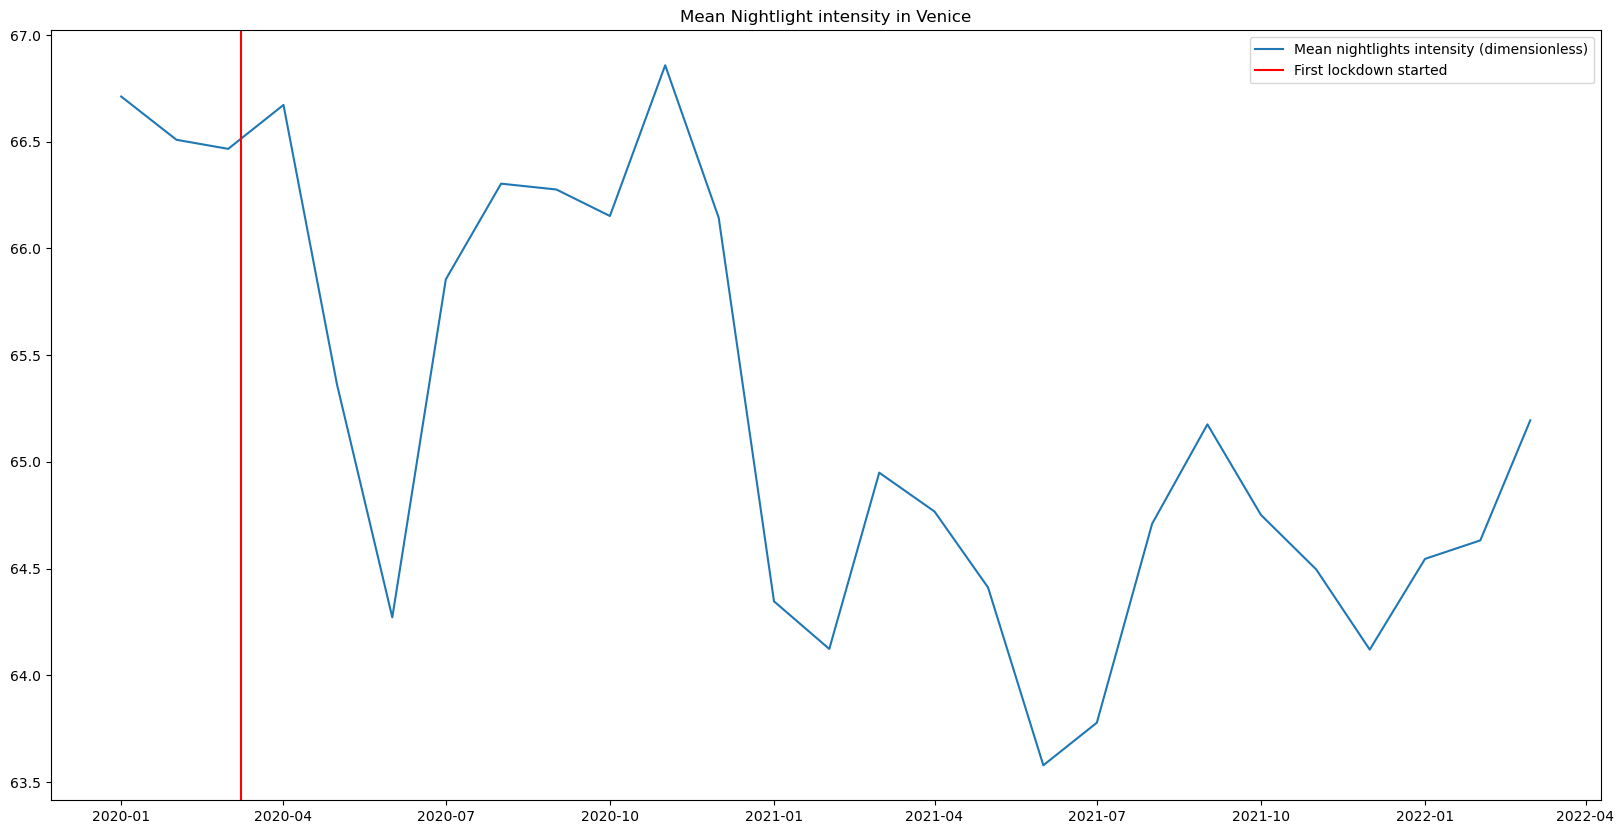

In [8]:
# Plot mean nightlights intensity values 
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20,10))
plt.plot(dates, means, label="Mean nightlights intensity (dimensionless)")
plt.axvline(datetime(2020,3,8).timestamp()/60/60/24, color="r", label="First lockdown started")
plt.title("Mean Nightlight intensity in Venice")
plt.legend()

### In the next section we wil use the raster tiles themselves to perform a pixel-by-pixel variance calculation

In [9]:
# View Tilejson for a single feature,  which includes a preformatted URL we can use to request the tiles from 
# the raster API
tilejson = re.get(
        f"{RASTER_ENDPOINT_URL}/stac/tilejson.json?collection={features[0]['collection']}&item={features[0]['id']}&assets=cog_default&bidx=1&unscale=false&resampling=nearest&max_size=1024&rescale=0%2C255&colormap_name=inferno", 
    ).json()
tilejson


{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://staging-raster.delta-backend.com/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nightlights-hd-monthly&item=finalBMHD_ScaledVenice_201901&assets=cog_default&bidx=1&unscale=false&resampling=nearest&max_size=1024&rescale=0%2C255&colormap_name=inferno'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [11.7631744, 45.06062636, 12.79039608, 45.79310055],
 'center': [12.27678524, 45.426863455, 0]}

In [10]:
from ipyleaflet import TileLayer

m = Map(
    basemap=basemaps.OpenStreetMap.Mapnik,
    center=(45,14),
    zoom=6,
    scroll_wheel_zoom=True
)

tile_layer = TileLayer(url=tilejson["tiles"][0], min_zoom=tilejson["minzoom"], max_zoom=tilejson["maxzoom"])
m.add_layer(tile_layer)
m


Map(center=[45, 14], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [11]:
# Use morecantile to calculate the Web mercator (row/x, column/y, zoom/z) tiles we want to query, 
# given the lat/lon bounding box

!{sys.executable} -m pip install morecantile
import morecantile

zoom_level = 5
tms = morecantile.tms.get("WebMercatorQuad")
corner_tiles = [tms._tile(*tms.xy(*pair),zoom_level) for pair in [(e,s), (e,n), (w,n), (w,s)]]
min_x, max_x = min(t.x for t in corner_tiles), max(t.x for t in corner_tiles)
min_y, max_y = min(t.y for t in corner_tiles), max(t.y for t in corner_tiles)
tiles = [morecantile.Tile(x,y,zoom_level) for x in range(min_x, max_x+1) for y in range(min_y, max_y+1)]
tiles


[Tile(x=17, y=11, z=5)]

Zoom level 5 is the lowest zoom level at which the Venice bounding box is entirely contained within a single Web-mercator tile

In [12]:
[tile] = tiles
r = re.get(
       tilejson["tiles"][0].replace("{z}/{x}/{y}", f"{tile.z}/{tile.x}/{tile.y}")
   )
r.status_code

200

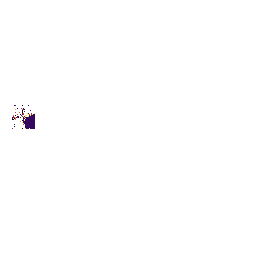

In [13]:
import io
from PIL import Image

im = Image.open(io.BytesIO(r.content))
im

Obviously this zoom level is too low, so we will need to request tiles for higher zoom levels and mosaic them together

In [14]:
zoom_level = 10
tms = morecantile.tms.get("WebMercatorQuad")
corner_tiles = [tms._tile(*tms.xy(*pair),zoom_level) for pair in [(e,s), (e,n), (w,n), (w,s)]]
min_x, max_x = min(t.x for t in corner_tiles), max(t.x for t in corner_tiles)
min_y, max_y = min(t.y for t in corner_tiles), max(t.y for t in corner_tiles)
tiles = [morecantile.Tile(x,y,zoom_level) for x in range(min_x, max_x+1) for y in range(min_y, max_y+1)]
tiles

[Tile(x=545, y=365, z=10),
 Tile(x=545, y=366, z=10),
 Tile(x=545, y=367, z=10),
 Tile(x=545, y=368, z=10),
 Tile(x=546, y=365, z=10),
 Tile(x=546, y=366, z=10),
 Tile(x=546, y=367, z=10),
 Tile(x=546, y=368, z=10),
 Tile(x=547, y=365, z=10),
 Tile(x=547, y=366, z=10),
 Tile(x=547, y=367, z=10),
 Tile(x=547, y=368, z=10),
 Tile(x=548, y=365, z=10),
 Tile(x=548, y=366, z=10),
 Tile(x=548, y=367, z=10),
 Tile(x=548, y=368, z=10)]

At zoom level 10 the Venice bounding box is contained within 16 Web-mercator tiles

In [15]:
#!{sys.executable} -m pip install numpy==1.21
import numpy as np

from concurrent.futures import ThreadPoolExecutor

def _get_raster(tilejson_url, tile):
    r = re.get(tilejson_url.replace("{z}/{x}/{y}", f"{tile.z}/{tile.x}/{tile.y}"))
    if not r.status_code == 200: 
        raise Exception(r.content)
    a = np.array(Image.open(io.BytesIO(r.content)))
    return a, (tile.y-min_y)*256, (tile.y-min_y+1)*256, (tile.x-min_x)*256, (tile.x-min_x+1)*256
    
    
    
# Define a function which will request each of the 16 web-mercator tiles and insert it into a 
# single mosaic'ed image
def mosaic_image(feature, tiles):
    canvas = np.zeros(((max_x - min_x+1)*256, (max_y-min_y+1)*256))
    
    tilejson_url = re.get(
            f"{RASTER_ENDPOINT_URL}/stac/tilejson.json?collection={feature['collection']}&item={feature['id']}&assets=cog_default&bidx=1&unscale=false&resampling=nearest&max_size=1024&rescale=0%2C255", 
    ).json()["tiles"][0]
        
   
    
    with ThreadPoolExecutor(max_workers=10) as executor: 
        result = executor.map(_get_raster, [tilejson_url for _ in tiles], tiles)

    for a, ymin, ymax, xmin, xmax in result: 
        canvas[ymin:ymax,xmin:xmax] = a[:,:,0]
    return canvas
    

In [16]:

# define a 3D array that will hold all of the composite (mosaic) images we generate
datacube = np.zeros(((max_x - min_x+1)*256, (max_y-min_y+1)*256, len(features)))

for i, feature in enumerate(features): 
    print(f"Feature {i} out of {len(features)}")

    image = mosaic_image(
        feature = feature,
        tiles=tiles
    )
    datacube[:,:,i] = image


Feature 0 out of 39


Feature 1 out of 39


Feature 2 out of 39


Feature 3 out of 39


Feature 4 out of 39


Feature 5 out of 39


Feature 6 out of 39


Feature 7 out of 39


Feature 8 out of 39


Feature 9 out of 39


Feature 10 out of 39


Feature 11 out of 39


Feature 12 out of 39


Feature 13 out of 39


Feature 14 out of 39


Feature 15 out of 39


Feature 16 out of 39


Feature 17 out of 39


Feature 18 out of 39


Feature 19 out of 39


Feature 20 out of 39


Feature 21 out of 39


Feature 22 out of 39


Feature 23 out of 39


Feature 24 out of 39


Feature 25 out of 39


Feature 26 out of 39


Feature 27 out of 39


Feature 28 out of 39


Feature 29 out of 39


Feature 30 out of 39


Feature 31 out of 39


Feature 32 out of 39


Feature 33 out of 39


Feature 34 out of 39


Feature 35 out of 39


Feature 36 out of 39


Feature 37 out of 39


Feature 38 out of 39


/opt/conda/envs/edc-default-2023.03-02/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/envs/edc-default-2023.03-02/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',


/opt/conda/envs/edc-default-2023.03-02/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


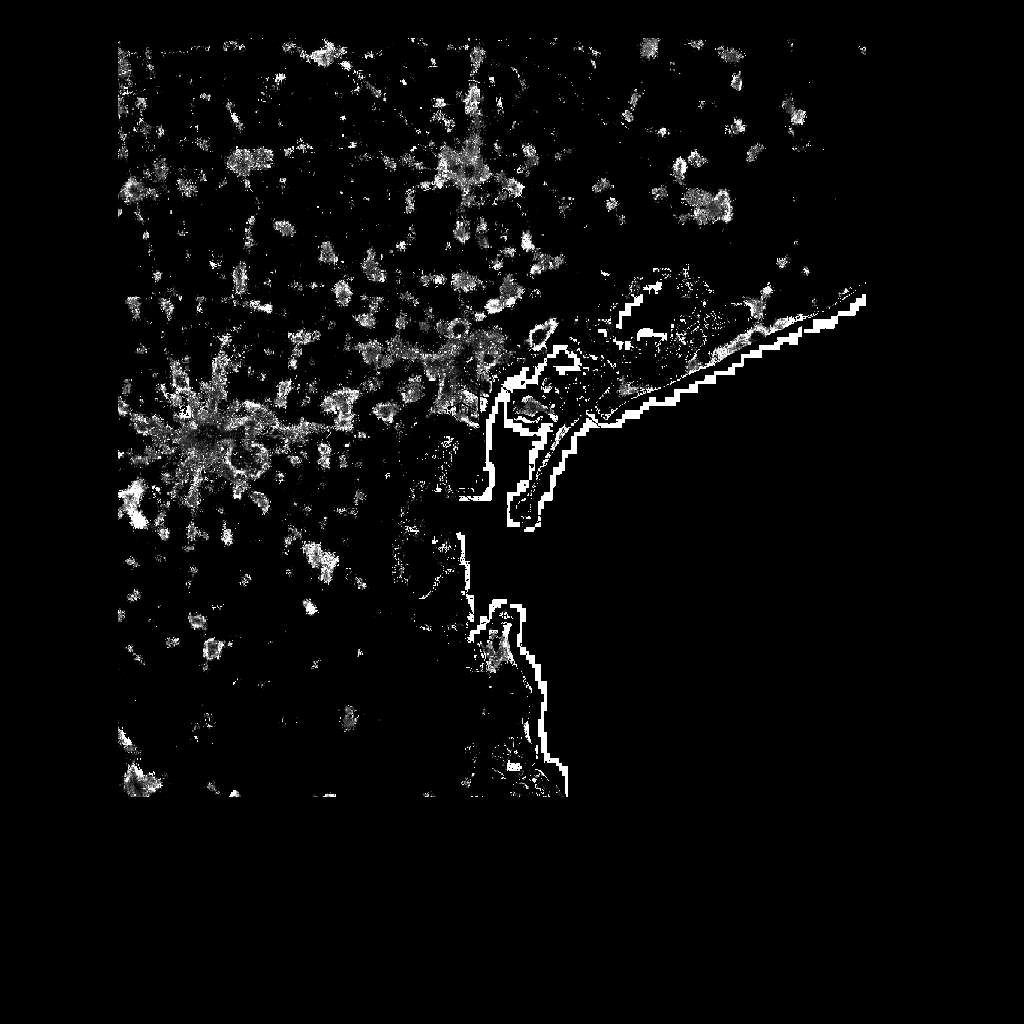

In [17]:
# Calculate the variance of the 3D array along the 3rd axis (time)
# ignoring 0/nan values 
var_array = np.var(datacube, axis=2, where=datacube > 0)

im = Image.fromarray(var_array).convert("RGB")
im

Looking at the variance map above, we can see that while the city centers did not experience much change in nightlight intensity throughout the lockdown, re-opening and re-lockdown periods of 2020-2021, the areas _around_ the city centers display the greatest variance 

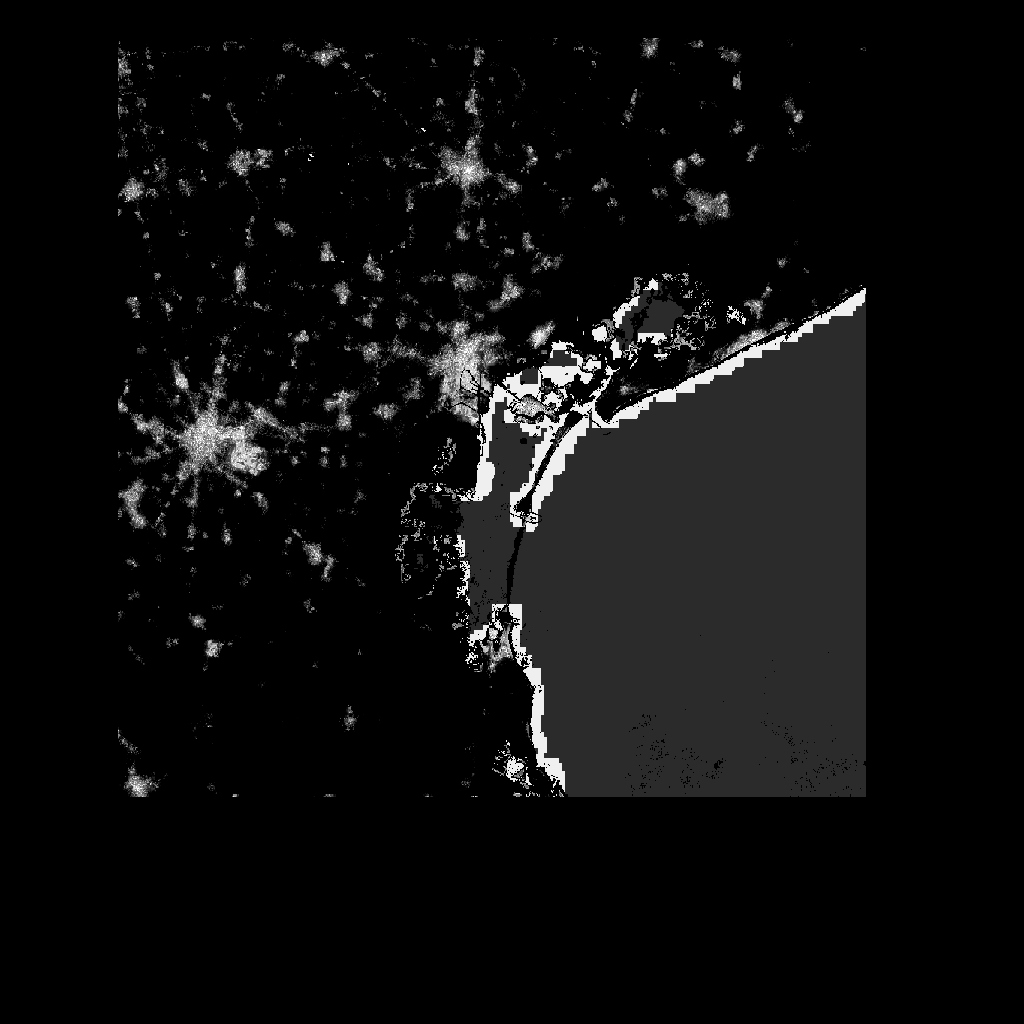

In [18]:
# For reference here is a image of the nightlights itensity before the lockdown
im = Image.fromarray(datacube[:,:,0]).convert("RGB")
im